# Simulations for the sensitivity analysis

The sensitivity analysis tests the sensitivity of outcomes to a variety of dimensions:
* ventilation efficiency [usual parameters]
* efficiency of masks [additional model parameters]
* adherence to voluntary testing (testing rate) [additional agent parameters]
* adherence to class size reductions (reduzed class size) [different contact network source]
* sensitivity of antigen tests [usual parameters]
* additional contacts between students through firendships [different contact network source]
* virus transmissibility [additional model parameter]

analysis | primary | primar_dc | lower_secondary | lower_secondary_dc | upper secondary | secondary | 
-------- | ------- | --------- | --------------- | ------------------ | --------------- | --------
ventilation efficiency | running | running | running | running | running | running |
testing rate | running | running | running | running | running | running |
mask efficiency | running | running | running | running | running | - |
test sensitivity | - | - | - | - | - | - |
class size reduction | - | - | - | - | - | - |
added contacts | - | - | - | - | - | - |

In [1]:
import pandas as pd
import numpy as np
from os.path import join
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

from scseirx import analysis_functions as af
import data_creation_functions as dcf

# parallelisation functionality
from multiprocess import Pool
import psutil
from tqdm import tqdm

## Simulation settings

In [3]:
with open('params/sensitivity_analysis_measures.json', 'r') as fp:
    measures = json.load(fp)
with open('params/sensitivity_analysis_simulation_parameters.json', 'r') as fp:
    simulation_params = json.load(fp)
with open('params/sensitivity_analysis_school_characteristics.json', 'r') as fp:
    school_characteristics = json.load(fp)

## Ventilation efficiency

### Screening parameters

In [4]:
# number of runs in the ensemble (set to a low number so runs complete quickly
# for demonstration purposes)
N_runs = 10
# different school types (only simulate for primary schools for demonstration
# purposes)
school_types = ['primary', 'primary_dc', 'lower_secondary',
                'lower_secondary_dc', 'upper_secondary', 'secondary'][0:1]
# load the other screening parameters from file
screening_params = pd.read_csv(join('screening_params', 'ventilation_efficiency.csv'))

params = [(N_runs, st, 
           row['index_case'],
           dcf.format_none_column(row['s_screen_interval']),
           dcf.format_none_column(row['t_screen_interval']),
           row['s_mask'],
           row['t_mask'], 
           row['class_size_reduction'],
           row['ventilation_modification']) \
           for st in school_types \
           for i, row in screening_params.iterrows()]

### Simulation function

In [5]:
def run_ventilation_efficiency(params):
    '''
    Runs an ensemble of simulations and collects observable statistics. To be 
    run in parallel on many workers. Note: I/O paths and the number of runs per 
    ensemble hare hard coded here, because I only want to pass the parameter 
    values that are being screened in the simulation run to the function via the
    parallel processing interface.
    
    Parameters:
    -----------
    param_list : iterable
        Iterable that contains the values for the parameters N_runs, 
        school_type, index_case, s_screen_interval, t_screen_interval, s_mask,
        t_mask, class_size_reduction and ventilation_modification. 
        These parameters are passed to the simulation.
        
    Returns:
    --------
    row : dictionary
        Dictionary of the ensemble statistics of the observables.
    '''    

    # extract the simulation parameters from the parameter list
    N_runs, school_type, index_case, s_screen_interval, t_screen_interval, \
        student_mask, teacher_mask, class_size_reduction, ventilation_mod, \
        = params
    
    try:
        os.mkdir(join(dst, school_type))
    except FileExistsError:
        pass

    # run the ensemble with the given parameter combination and school type
    ensmbl_results = dcf.run_ensemble(N_runs, school_type, measures,\
            simulation_params, school_characteristics, contact_network_src,\
            dst, index_case, s_screen_interval=s_screen_interval,
            t_screen_interval=t_screen_interval, student_mask=student_mask,
            teacher_mask=teacher_mask, 
            class_size_reduction=class_size_reduction,
            ventilation_mod=ventilation_mod)
    
    return ensmbl_results

### Running the simulations

In [9]:
%%time
# paths for data I/O
contact_network_src = '../../data/contact_networks/representative_schools'
dst = '../../data/sensitivity_analysis/simulation_results/ventilation_efficiency'

number_of_cores = psutil.cpu_count(logical=True) - 2
pool = Pool(number_of_cores)

results = pd.DataFrame()
for ensmbl_results in tqdm(pool.imap_unordered(func=run_ventilation_efficiency,
                        iterable=params), total=len(params)):
    results = results.append(ensmbl_results, ignore_index=True)

# turn off your parallel workers 
pool.close()
    
results = results.reset_index(drop=True)
index_cols = ['school_type', 'index_case',
              'student_screen_interval', 'teacher_screen_interval',
              'student_mask', 'teacher_mask', 'class_size_reduction',
              'ventilation_mod']
other_cols = [c for c in results.columns if c not in index_cols]
results = results[index_cols + other_cols]

results.to_csv(join(dst, 'ventilation_efficiency_{}.csv'\
                   .format(N_runs)), index=False)
results.head(3)

100%|██████████| 64/64 [01:05<00:00,  1.03s/it]

CPU times: user 788 ms, sys: 155 ms, total: 944 ms
Wall time: 1min 5s


,school_type,index_case,student_screen_interval,teacher_screen_interval,student_mask,teacher_mask,class_size_reduction,ventilation_mod,N_diagnostic_tests,N_family_members,...,test_type,student_testing_rate,teacher_testing_rate,base_transmission_risk_multiplier,mask_efficiency_exhale,mask_efficiency_inhale,friendship_ratio,student_vaccination_ratio,teacher_vaccination_ratio,family_member_vaccination_ratio
0,primary,teacher,None,None,False,False,0.0,0.3,4.0,346.0,...,same_day_antigen,1.0,1.0,1.0,0.5,0.7,0.0,0.0,0.0,0.0
1,primary,teacher,None,None,False,False,0.0,0.3,1.0,346.0,...,same_day_antigen,1.0,1.0,1.0,0.5,0.7,0.0,0.0,0.0,0.0
2,primary,teacher,None,None,False,False,0.0,0.3,5.0,346.0,...,same_day_antigen,1.0,1.0,1.0,0.5,0.7,0.0,0.0,0.0,0.0


### Evaluate the simulations

In [20]:
dst = '../../data/sensitivity_analysis/simulation_results/ventilation_efficiency'
results = pd.read_csv(join(dst, 'ventilation_efficiency_{}.csv'.format(N_runs)))
results['student_screen_interval'] = results['student_screen_interval']\
    .replace({np.nan:'never'})
results['teacher_screen_interval'] = results['teacher_screen_interval']\
    .replace({np.nan:'never'})
dcf.set_measure_packages_ventilation_efficiency(results)

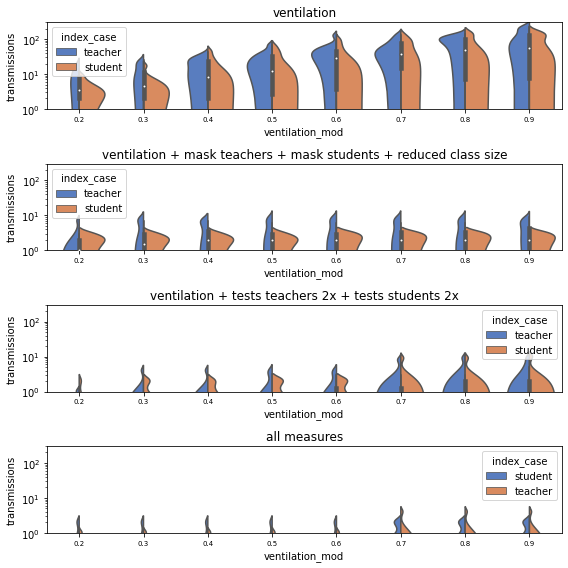

In [34]:
fig, axes = plt.subplots(4, 1, figsize=(8, 8))

for ax, measure in zip(axes.flatten(), results['measure'].unique()):
    subset = results[results['measure'] == measure]
    sns.violinplot(x="ventilation_mod", y="transmissions", hue="index_case",
                        data=subset, palette="muted", split=True, ax=ax)
    ax.tick_params(axis='x', labelsize=7)
    ax.set_yscale('log')
    ax.set_ylim(1, 300)
    ax.set_title(measure)
fig.tight_layout()

## Mask efficiency

### Screening parameters

In [39]:
# number of runs in the ensemble (set to a low number so runs complete quickly
# for demonstration purposes)
N_runs = 10
# different school types (only simulate for primary schools for demonstration
# purposes)
school_types = ['primary', 'primary_dc', 'lower_secondary',
                'lower_secondary_dc', 'upper_secondary', 'secondary'][0:1]
# load the other screening parameters from file
screening_params = pd.read_csv(join('screening_params', 'mask_efficiency.csv'))

params = [(N_runs, st, 
           row['index_case'],
           dcf.format_none_column(row['s_screen_interval']),
           dcf.format_none_column(row['t_screen_interval']),
           row['s_mask'],
           row['t_mask'], 
           row['class_size_reduction'],
           row['ventilation_modification'],
           row['m_efficiency_exhale'],
           row['m_efficiency_inhale']) \
           for st in school_types \
           for i, row in screening_params.iterrows()]

### Simulation function

In [40]:
def run_mask_efficiency(params):
    '''
    Runs an ensemble of simulations and collects observable statistics. To be 
    run in parallel on many workers. Note: I/O paths and the number of runs per 
    ensemble hare hard coded here, because I only want to pass the parameter 
    values that are being screened in the simulation run to the function via the
    parallel processing interface.
    
    Parameters:
    -----------
    param_list : iterable
        Iterable that contains the values for the parameters N_runs, 
        school_type, index_case, s_screen_interval, t_screen_interval, s_mask,
        t_mask, class_size_reduction, mask_efficiency_exhale and
        mask_efficiency_inhale. These parameters are passed to the simulation.
        
    Returns:
    --------
    row : dictionary
        Dictionary of the ensemble statistics of the observables.
    '''    

    # extract the simulation parameters from the parameter list
    N_runs, school_type, index_case, s_screen_interval, t_screen_interval, \
        student_mask, teacher_mask, class_size_reduction, ventilation_mod, \
        m_efficiency_exhale, m_efficiency_inhale = params
    
    try:
        os.mkdir(join(dst, school_type))
    except FileExistsError:
        pass

    # run the ensemble with the given parameter combination and school type
    ensmbl_results = dcf.run_ensemble(N_runs, school_type, measures,\
            simulation_params, school_characteristics, contact_network_src,\
            dst, index_case, s_screen_interval=s_screen_interval,
            t_screen_interval=t_screen_interval, student_mask=student_mask,
            teacher_mask=teacher_mask, 
            class_size_reduction=class_size_reduction,
            ventilation_mod=ventilation_mod,
            mask_efficiency_exhale=m_efficiency_exhale,
            mask_efficiency_inhale=m_efficiency_inhale)
    
    return ensmbl_results

### Running the simulations

In [41]:
%%time
# paths for data I/O
contact_network_src = '../../data/contact_networks/representative_schools'
dst = '../../data/sensitivity_analysis/simulation_results/mask_efficiency'

number_of_cores = psutil.cpu_count(logical=True) - 2
pool = Pool(number_of_cores)

results = pd.DataFrame()
for ensmbl_results in tqdm(pool.imap_unordered(func=run_mask_efficiency,
                        iterable=params), total=len(params)):
    results = results.append(ensmbl_results, ignore_index=True)

# turn off your parallel workers 
pool.close()
    
results = results.reset_index(drop=True)
index_cols = ['school_type', 'index_case',
              'student_screen_interval', 'teacher_screen_interval',
              'student_mask', 'teacher_mask', 'class_size_reduction',
              'ventilation_mod', 'mask_efficiency_exhale',
              'mask_efficiency_inhale']
other_cols = [c for c in results.columns if c not in index_cols]
results = results[index_cols + other_cols]

results.to_csv(join(dst, 'mask_efficiency_{}.csv'\
                   .format(N_runs)), index=False)
results.head(3)

100%|██████████| 56/56 [00:53<00:00,  1.05it/s]

CPU times: user 753 ms, sys: 173 ms, total: 926 ms
Wall time: 53.6 s


,school_type,index_case,student_screen_interval,teacher_screen_interval,student_mask,teacher_mask,class_size_reduction,ventilation_mod,N_diagnostic_tests,N_family_members,...,test_type,student_testing_rate,teacher_testing_rate,base_transmission_risk_multiplier,mask_efficiency_exhale,mask_efficiency_inhale,friendship_ratio,student_vaccination_ratio,teacher_vaccination_ratio,family_member_vaccination_ratio
0,primary,teacher,None,None,True,True,0.0,1.0,0.0,346.0,...,same_day_antigen,1.0,1.0,1.0,0.1,0.3,0.0,0.0,0.0,0.0
1,primary,teacher,None,None,True,True,0.0,1.0,1.0,346.0,...,same_day_antigen,1.0,1.0,1.0,0.1,0.3,0.0,0.0,0.0,0.0
2,primary,teacher,None,None,True,True,0.0,1.0,0.0,346.0,...,same_day_antigen,1.0,1.0,1.0,0.1,0.3,0.0,0.0,0.0,0.0


### Evaluate the simulations

In [44]:
dst = '../../data/sensitivity_analysis/simulation_results/mask_efficiency'
results = pd.read_csv(join(dst, 'mask_efficiency_{}.csv'.format(N_runs)))
results['student_screen_interval'] = results['student_screen_interval']\
    .replace({np.nan:'never'})
results['teacher_screen_interval'] = results['teacher_screen_interval']\
    .replace({np.nan:'never'})
dcf.set_measure_packages_mask_efficiency(results)

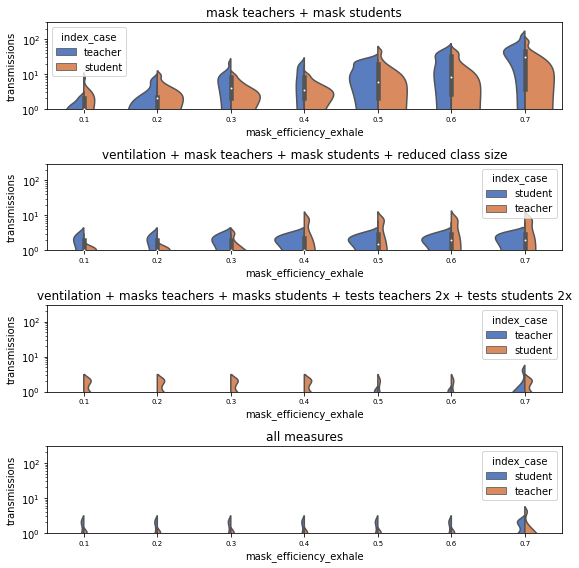

In [46]:
fig, axes = plt.subplots(4, 1, figsize=(8, 8))

for ax, measure in zip(axes.flatten(), results['measure'].unique()):
    subset = results[results['measure'] == measure]
    sns.violinplot(x="mask_efficiency_exhale", y="transmissions", hue="index_case",
                        data=subset, palette="muted", split=True, ax=ax)
    ax.tick_params(axis='x', labelsize=7)
    ax.set_yscale('log')
    ax.set_ylim(1, 300)
    ax.set_title(measure)
fig.tight_layout()

## Testing rate

### Screening parameters

In [47]:
# number of runs in the ensemble (set to a low number so runs complete quickly
# for demonstration purposes)
N_runs = 10
# different school types (only simulate for primary schools for demonstration
# purposes)
school_types = ['primary', 'primary_dc', 'lower_secondary',
                'lower_secondary_dc', 'upper_secondary', 'secondary'][0:1]
# load the other screening parameters from file
screening_params = pd.read_csv(join('screening_params', 'testing_rate.csv'))

params = [(N_runs, st, 
           row['index_case'],
           dcf.format_none_column(row['s_screen_interval']),
           dcf.format_none_column(row['t_screen_interval']),
           row['s_mask'],
           row['t_mask'], 
           row['class_size_reduction'],
           row['ventilation_modification'],
           row['s_test_rate'],
           row['t_test_rate']) \
           for st in school_types \
           for i, row in screening_params.iterrows()]

### Simulation function

In [48]:
def run_testing_rate(params):
    '''
    Runs an ensemble of simulations and collects observable statistics. To be 
    run in parallel on many workers. Note: I/O paths and the number of runs per 
    ensemble hare hard coded here, because I only want to pass the parameter 
    values that are being screened in the simulation run to the function via the
    parallel processing interface.
    
    Parameters:
    -----------
    param_list : iterable
        Iterable that contains the values for the parameters N_runs, 
        school_type, index_case, s_screen_interval, t_screen_interval, s_mask,
        t_mask, class_size_reduction and s_testing_rate and t_testing_rate. 
        These parameters are passed to the simulation.
        
    Returns:
    --------
    row : dictionary
        Dictionary of the ensemble statistics of the observables.
    '''    

    # extract the simulation parameters from the parameter list
    N_runs, school_type, index_case, s_screen_interval, t_screen_interval, \
        student_mask, teacher_mask, class_size_reduction, ventilation_mod, \
        s_testing_rate, t_testing_rate = params
    
    try:
        os.mkdir(join(dst, school_type))
    except FileExistsError:
        pass

    # run the ensemble with the given parameter combination and school type
    ensmbl_results = dcf.run_ensemble(N_runs, school_type, measures,\
            simulation_params, school_characteristics, contact_network_src,\
            dst, index_case, s_screen_interval=s_screen_interval,
            t_screen_interval=t_screen_interval, student_mask=student_mask,
            teacher_mask=teacher_mask, 
            class_size_reduction=class_size_reduction,
            ventilation_mod=ventilation_mod,
            s_testing_rate=s_testing_rate,
            t_testing_rate=t_testing_rate)
    
    return ensmbl_results

### Running the simulations

In [49]:
%%time
# paths for data I/O
contact_network_src = '../../data/contact_networks/representative_schools'
dst = '../../data/sensitivity_analysis/simulation_results/testing_rate'

number_of_cores = psutil.cpu_count(logical=True) - 2
pool = Pool(number_of_cores)

results = pd.DataFrame()
for ensmbl_results in tqdm(pool.imap_unordered(func=run_testing_rate,
                        iterable=params), total=len(params)):
    results = results.append(ensmbl_results, ignore_index=True)

# turn off your parallel workers 
pool.close()
    
results = results.reset_index(drop=True)
index_cols = ['school_type', 'index_case',
              'student_screen_interval', 'teacher_screen_interval',
              'student_mask', 'teacher_mask', 'class_size_reduction',
              'ventilation_mod', 'student_testing_rate', 'teacher_testing_rate']
other_cols = [c for c in results.columns if c not in index_cols]
results = results[index_cols + other_cols]

results.to_csv(join(dst, 'testing_rate_{}.csv'\
                   .format(N_runs)), index=False)
results.head(3)

100%|██████████| 90/90 [01:31<00:00,  1.02s/it]

CPU times: user 1.04 s, sys: 170 ms, total: 1.21 s
Wall time: 1min 31s


,school_type,index_case,student_screen_interval,teacher_screen_interval,student_mask,teacher_mask,class_size_reduction,ventilation_mod,student_testing_rate,teacher_testing_rate,...,transmissions,undetected_infections,test_type,base_transmission_risk_multiplier,mask_efficiency_exhale,mask_efficiency_inhale,friendship_ratio,student_vaccination_ratio,teacher_vaccination_ratio,family_member_vaccination_ratio
0,primary,student,7,7,False,False,0.0,1.0,0.9,0.9,...,0.0,0.0,same_day_antigen,1.0,0.5,0.7,0.0,0.0,0.0,0.0
1,primary,student,7,7,False,False,0.0,1.0,0.9,0.9,...,0.0,0.0,same_day_antigen,1.0,0.5,0.7,0.0,0.0,0.0,0.0
2,primary,student,7,7,False,False,0.0,1.0,0.9,0.9,...,0.0,0.0,same_day_antigen,1.0,0.5,0.7,0.0,0.0,0.0,0.0


### Evaluate the simulations

In [52]:
dst = '../../data/sensitivity_analysis/simulation_results/testing_rate'
results = pd.read_csv(join(dst, 'testing_rate_{}.csv'.format(N_runs)))
dcf.set_measure_packages_testing_rate(results)

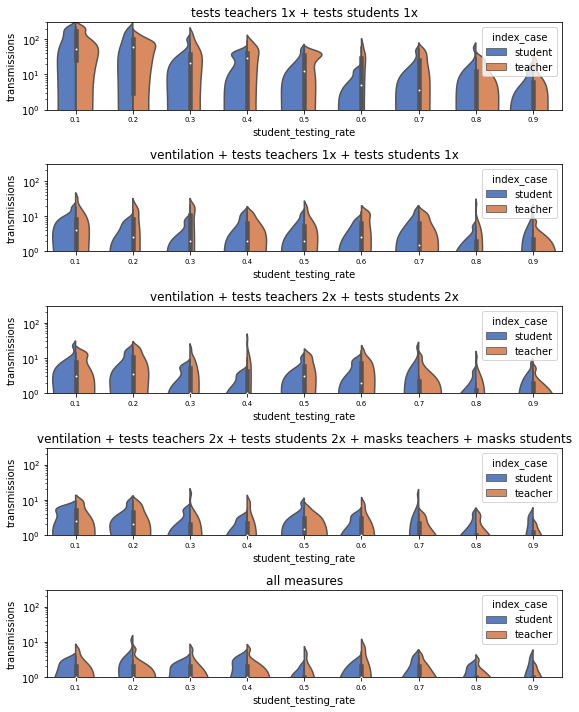

In [59]:
fig, axes = plt.subplots(5, 1, figsize=(8, 10))

for ax, measure in zip(axes.flatten(), results['measure'].unique()):
    subset = results[results['measure'] == measure]
    sns.violinplot(x="student_testing_rate", y="transmissions", hue="index_case",
                        data=subset, palette="muted", split=True, ax=ax)
    ax.tick_params(axis='x', labelsize=7)
    ax.set_yscale('log')
    ax.set_ylim(1, 300)
    ax.set_title(measure)
fig.tight_layout()

## Test sensitivity

### Screening parameters

In [60]:
# number of runs in the ensemble (set to a low number so runs complete quickly
# for demonstration purposes)
N_runs = 10
# different school types (only simulate for primary schools for demonstration
# purposes)
school_types = ['primary', 'primary_dc', 'lower_secondary',
                'lower_secondary_dc', 'upper_secondary', 'secondary'][0:1]
# load the other screening parameters from file
screening_params = pd.read_csv(join('screening_params', 'test_sensitivity.csv'))

params = [(N_runs, st, 
           row['index_case'],
           dcf.format_none_column(row['s_screen_interval']),
           dcf.format_none_column(row['t_screen_interval']),
           row['s_mask'],
           row['t_mask'], 
           row['class_size_reduction'],
           row['ventilation_modification'],
           row['ttype']) \
           for st in school_types \
           for i, row in screening_params.iterrows()]

### Simulation function

In [61]:
def run_test_sensitivity(params):
    '''
    Runs an ensemble of simulations and collects observable statistics. To be 
    run in parallel on many workers. Note: I/O paths and the number of runs per 
    ensemble hare hard coded here, because I only want to pass the parameter 
    values that are being screened in the simulation run to the function via the
    parallel processing interface.
    
    Parameters:
    -----------
    param_list : iterable
        Iterable that contains the values for the parameters N_runs, 
        school_type, index_case, s_screen_interval, t_screen_interval, s_mask,
        t_mask, class_size_reduction and ttype, which encodes the test 
        sensitivity. These parameters are passed to the simulation.
        
    Returns:
    --------
    row : dictionary
        Dictionary of the ensemble statistics of the observables.
    '''    

    # extract the simulation parameters from the parameter list
    N_runs, school_type, index_case, s_screen_interval, t_screen_interval, \
        student_mask, teacher_mask, class_size_reduction, ventilation_mod, \
        ttype = params
    
    try:
        os.mkdir(join(dst, school_type))
    except FileExistsError:
        pass

    # run the ensemble with the given parameter combination and school type
    ensmbl_results = dcf.run_ensemble(N_runs, school_type, measures,\
            simulation_params, school_characteristics, contact_network_src,\
            dst, index_case, s_screen_interval=s_screen_interval,
            t_screen_interval=t_screen_interval, student_mask=student_mask,
            teacher_mask=teacher_mask, 
            class_size_reduction=class_size_reduction,
            ventilation_mod=ventilation_mod, ttype=ttype)
    
    return ensmbl_results

### Running the simulations

In [63]:
%%time
# paths for data I/O
contact_network_src = '../../data/contact_networks/representative_schools'
dst = '../../data/sensitivity_analysis/simulation_results/test_sensitivity'

number_of_cores = psutil.cpu_count(logical=True) - 2
pool = Pool(number_of_cores)

results = pd.DataFrame()
for ensmbl_results in tqdm(pool.imap_unordered(func=run_test_sensitivity,
                        iterable=params), total=len(params)):
    results = results.append(ensmbl_results, ignore_index=True)

# turn off your parallel workers 
pool.close()
    
results = results.reset_index(drop=True)
index_cols = ['school_type', 'index_case',
              'student_screen_interval', 'teacher_screen_interval',
              'student_mask', 'teacher_mask', 'class_size_reduction',
              'ventilation_mod', 'test_type',]
other_cols = [c for c in results.columns if c not in index_cols]
results = results[index_cols + other_cols]

results.to_csv(join(dst, 'test_sensitivity_{}.csv'\
                   .format(N_runs)), index=False)
results.head(3)

100%|██████████| 90/90 [01:29<00:00,  1.01it/s]

CPU times: user 1.04 s, sys: 195 ms, total: 1.24 s
Wall time: 1min 29s


,school_type,index_case,student_screen_interval,teacher_screen_interval,student_mask,teacher_mask,class_size_reduction,ventilation_mod,test_type,N_diagnostic_tests,...,undetected_infections,student_testing_rate,teacher_testing_rate,base_transmission_risk_multiplier,mask_efficiency_exhale,mask_efficiency_inhale,friendship_ratio,student_vaccination_ratio,teacher_vaccination_ratio,family_member_vaccination_ratio
0,primary,student,7,7,False,False,0.0,1.0,same_day_antigen0.4,0.0,...,1.0,1.0,1.0,1.0,0.5,0.7,0.0,0.0,0.0,0.0
1,primary,student,7,7,False,False,0.0,1.0,same_day_antigen0.4,0.0,...,0.0,1.0,1.0,1.0,0.5,0.7,0.0,0.0,0.0,0.0
2,primary,student,7,7,False,False,0.0,1.0,same_day_antigen0.4,16.0,...,2.0,1.0,1.0,1.0,0.5,0.7,0.0,0.0,0.0,0.0


### Evaluate the simulations

In [64]:
dst = '../../data/sensitivity_analysis/simulation_results/test_sensitivity'
results = pd.read_csv(join(dst, 'test_sensitivity_{}.csv'.format(N_runs)))
# note: the test sensitivity simulations use the same function to assign
# measure scenarios, since the scenarios are the same
dcf.set_measure_packages_testing_rate(results)

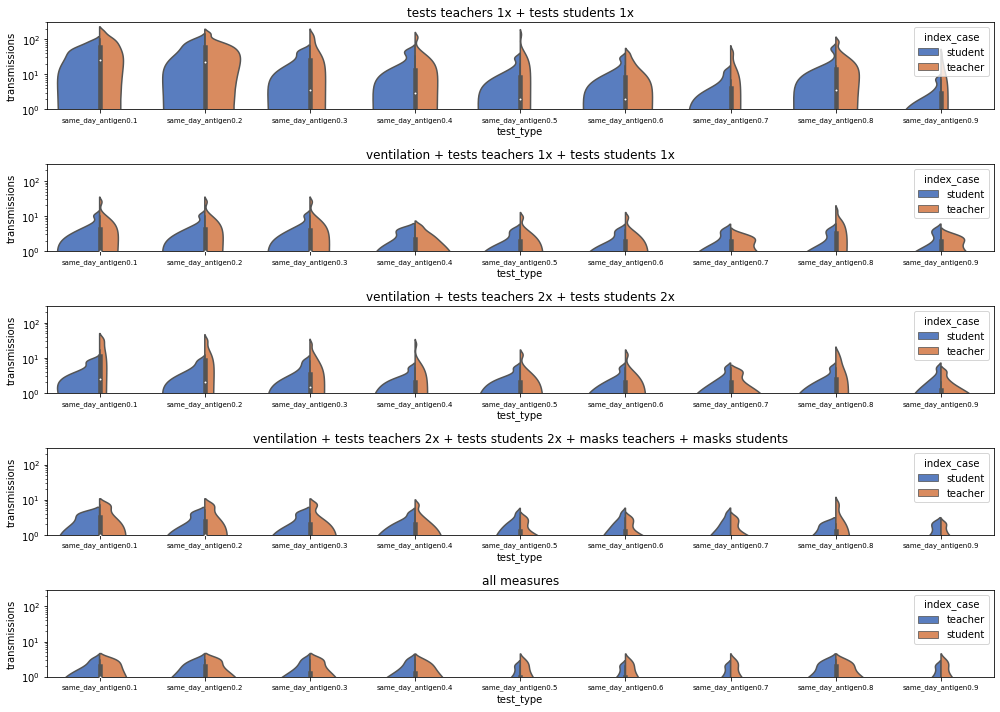

In [67]:
fig, axes = plt.subplots(5, 1, figsize=(14, 10))

order = ['same_day_antigen0.1', 'same_day_antigen0.2', 'same_day_antigen0.3',
         'same_day_antigen0.4', 'same_day_antigen0.5', 'same_day_antigen0.6',
         'same_day_antigen0.7', 'same_day_antigen0.8', 'same_day_antigen0.9']

for ax, measure in zip(axes.flatten(), results['measure'].unique()):
    subset = results[results['measure'] == measure]
    sns.violinplot(x="test_type", y="transmissions", hue="index_case",
                   data=subset, palette="muted", split=True, ax=ax,
                   order=order)
    ax.tick_params(axis='x', labelsize=7)
    ax.set_yscale('log')
    ax.set_ylim(1, 300)
    ax.set_title(measure)
fig.tight_layout()

## Reduced class size

### Screening parameters

In [68]:
# number of runs in the ensemble (set to a low number so runs complete quickly
# for demonstration purposes)
N_runs = 10
# different school types (only simulate for primary schools for demonstration
# purposes)
school_types = ['primary', 'primary_dc', 'lower_secondary',
                'lower_secondary_dc', 'upper_secondary', 'secondary'][0:1]
# load the other screening parameters from file
screening_params = pd.read_csv(join('screening_params', 'reduced_class_size.csv'))

params = [(N_runs, st, 
           row['index_case'],
           dcf.format_none_column(row['s_screen_interval']),
           dcf.format_none_column(row['t_screen_interval']),
           row['s_mask'],
           row['t_mask'], 
           row['class_size_reduction'],
           row['ventilation_modification']) \
           for st in school_types \
           for i, row in screening_params.iterrows()]

### Simulation function

In [69]:
def run_reduced_class_size(params):
    '''
    Runs an ensemble of simulations and collects observable statistics. To be 
    run in parallel on many workers. Note: I/O paths and the number of runs per 
    ensemble hare hard coded here, because I only want to pass the parameter 
    values that are being screened in the simulation run to the function via the
    parallel processing interface.
    
    Parameters:
    -----------
    param_list : iterable
        Iterable that contains the values for the parameters N_runs, 
        school_type, index_case, s_screen_interval, t_screen_interval, s_mask,
        t_mask, class_size_reduction and class_size_reduction. 
        These parameters are passed to the simulation.
        
    Returns:
    --------
    row : dictionary
        Dictionary of the ensemble statistics of the observables.
    '''    

    # extract the simulation parameters from the parameter list
    N_runs, school_type, index_case, s_screen_interval, t_screen_interval, \
        student_mask, teacher_mask, class_size_reduction, ventilation_mod, \
        = params
    
    try:
        os.mkdir(join(dst, school_type))
    except FileExistsError:
        pass

    # run the ensemble with the given parameter combination and school type
    ensmbl_results = dcf.run_ensemble(N_runs, school_type, measures,\
            simulation_params, school_characteristics, contact_network_src,\
            dst, index_case, s_screen_interval=s_screen_interval,
            t_screen_interval=t_screen_interval, student_mask=student_mask,
            teacher_mask=teacher_mask, 
            class_size_reduction=class_size_reduction,
            ventilation_mod=ventilation_mod)
    
    return ensmbl_results

### Running the simulations

In [74]:
%%time
# paths for data I/O
contact_network_src = '../../data/contact_networks/reduced_class_size'
dst = '../../data/sensitivity_analysis/simulation_results/reduced_class_size'

number_of_cores = psutil.cpu_count(logical=True) - 2
pool = Pool(number_of_cores)

results = pd.DataFrame()
for ensmbl_results in tqdm(pool.imap_unordered(func=run_reduced_class_size,
                        iterable=params), total=len(params)):
    results = results.append(ensmbl_results, ignore_index=True)

# turn off your parallel workers 
pool.close()
    
results = results.reset_index(drop=True)
index_cols = ['school_type', 'index_case',
              'student_screen_interval', 'teacher_screen_interval',
              'student_mask', 'teacher_mask', 'class_size_reduction',
              'ventilation_mod',]
other_cols = [c for c in results.columns if c not in index_cols]
results = results[index_cols + other_cols]

results.to_csv(join(dst, 'reduced_class_size_{}.csv'\
                   .format(N_runs)), index=False)
results.head(3)

100%|██████████| 48/48 [00:40<00:00,  1.19it/s]

CPU times: user 613 ms, sys: 173 ms, total: 786 ms
Wall time: 40.5 s


,school_type,index_case,student_screen_interval,teacher_screen_interval,student_mask,teacher_mask,class_size_reduction,ventilation_mod,N_diagnostic_tests,N_family_members,...,test_type,student_testing_rate,teacher_testing_rate,base_transmission_risk_multiplier,mask_efficiency_exhale,mask_efficiency_inhale,friendship_ratio,student_vaccination_ratio,teacher_vaccination_ratio,family_member_vaccination_ratio
0,primary,student,None,None,False,False,0.7,1.0,1.0,374.0,...,same_day_antigen,1.0,1.0,1.0,0.5,0.7,0.0,0.0,0.0,0.0
1,primary,student,None,None,False,False,0.7,1.0,1.0,374.0,...,same_day_antigen,1.0,1.0,1.0,0.5,0.7,0.0,0.0,0.0,0.0
2,primary,student,None,None,False,False,0.7,1.0,1.0,374.0,...,same_day_antigen,1.0,1.0,1.0,0.5,0.7,0.0,0.0,0.0,0.0


### Evaluate the simulations

In [81]:
dst = '../../data/sensitivity_analysis/simulation_results/reduced_class_size'
results = pd.read_csv(join(dst, 'reduced_class_size_{}.csv'.format(N_runs)))
results['student_screen_interval'] = results['student_screen_interval']\
    .replace({np.nan:'never'})
results['teacher_screen_interval'] = results['teacher_screen_interval']\
    .replace({np.nan:'never'})
dcf.set_measure_packages_reduced_class_size(results)

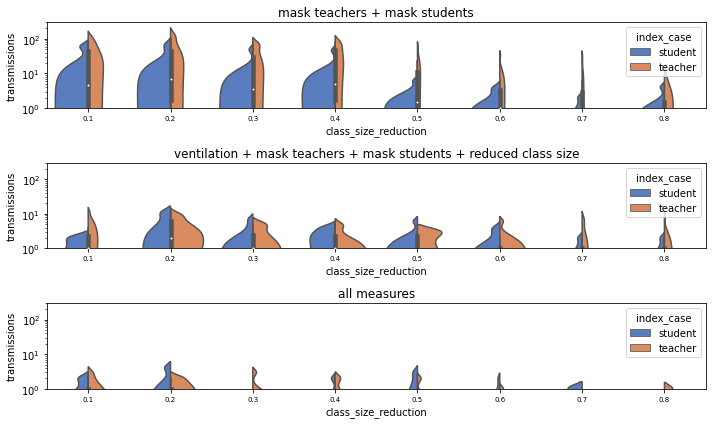

In [85]:
fig, axes = plt.subplots(3, 1, figsize=(10, 6))

for ax, measure in zip(axes.flatten(), results['measure'].unique()):
    subset = results[results['measure'] == measure]
    sns.violinplot(x="class_size_reduction", y="transmissions", hue="index_case",
                   data=subset, palette="muted", split=True, ax=ax)
    ax.tick_params(axis='x', labelsize=7)
    ax.set_yscale('log')
    ax.set_ylim(1, 300)
    ax.set_title(measure)
fig.tight_layout()

## Added friendship contacts

### Screening parameters

In [4]:
# number of runs in the ensemble (set to a low number so runs complete quickly
# for demonstration purposes)
N_runs = 10
# different school types (only simulate for primary schools for demonstration
# purposes)
school_types = ['primary', 'primary_dc', 'lower_secondary',
                'lower_secondary_dc', 'upper_secondary', 'secondary'][0:1]
# load the other screening parameters from file
screening_params = pd.read_csv(join('screening_params', 'added_friendship_contacts.csv'))

params = [(N_runs, st, 
           row['index_case'],
           dcf.format_none_column(row['s_screen_interval']),
           dcf.format_none_column(row['t_screen_interval']),
           row['s_mask'],
           row['t_mask'], 
           row['class_size_reduction'],
           row['ventilation_modification'],
           row['added_friendship_contacts']) \
           for st in school_types \
           for i, row in screening_params.iterrows()]

### Simulation function

In [5]:
def run_added_friendship_contacts(params):
    '''
    Runs an ensemble of simulations and collects observable statistics. To be 
    run in parallel on many workers. Note: I/O paths and the number of runs per 
    ensemble hare hard coded here, because I only want to pass the parameter 
    values that are being screened in the simulation run to the function via the
    parallel processing interface.
    
    Parameters:
    -----------
    param_list : iterable
        Iterable that contains the values for the parameters N_runs, 
        school_type, index_case, s_screen_interval, t_screen_interval, s_mask,
        t_mask, class_size_reduction and friendship_ratio, which encodes the
        ratio of students per class that will have added contacts to students
        from other classes. These parameters are passed to the simulation.
        
    Returns:
    --------
    row : dictionary
        Dictionary of the ensemble statistics of the observables.
    '''    

    # extract the simulation parameters from the parameter list
    N_runs, school_type, index_case, s_screen_interval, t_screen_interval, \
        student_mask, teacher_mask, class_size_reduction, ventilation_mod, \
        friendship_ratio = params
    
    try:
        os.mkdir(join(dst, school_type))
    except FileExistsError:
        pass

    # run the ensemble with the given parameter combination and school type
    ensmbl_results = dcf.run_ensemble(N_runs, school_type, measures,\
            simulation_params, school_characteristics, contact_network_src,\
            dst, index_case, s_screen_interval=s_screen_interval,
            t_screen_interval=t_screen_interval, student_mask=student_mask,
            teacher_mask=teacher_mask,class_size_reduction=class_size_reduction,
            ventilation_mod=ventilation_mod, friendship_ratio=friendship_ratio)
    
    return ensmbl_results

### Running the simulations

In [7]:
%%time
# paths for data I/O
contact_network_src = '../../data/contact_networks/added_friendship_contacts'
dst = '../../data/sensitivity_analysis/simulation_results/added_friendship_contacts'

number_of_cores = psutil.cpu_count(logical=True) - 2
pool = Pool(number_of_cores)

results = pd.DataFrame()
for ensmbl_results in tqdm(pool.imap_unordered(func=run_added_friendship_contacts,
                        iterable=params), total=len(params)):
    results = results.append(ensmbl_results, ignore_index=True)

# turn off your parallel workers 
pool.close()
    
results = results.reset_index(drop=True)
index_cols = ['school_type', 'index_case',
              'student_screen_interval', 'teacher_screen_interval',
              'student_mask', 'teacher_mask', 'class_size_reduction',
              'ventilation_mod', 'friendship_ratio']
other_cols = [c for c in results.columns if c not in index_cols]
results = results[index_cols + other_cols]

results.to_csv(join(dst, 'added_friendship_contacts_{}.csv'\
                   .format(N_runs)), index=False)
results.head(3)

100%|██████████| 80/80 [01:23<00:00,  1.04s/it]

CPU times: user 934 ms, sys: 162 ms, total: 1.1 s
Wall time: 1min 23s


,school_type,index_case,student_screen_interval,teacher_screen_interval,student_mask,teacher_mask,class_size_reduction,ventilation_mod,friendship_ratio,N_diagnostic_tests,...,undetected_infections,test_type,student_testing_rate,teacher_testing_rate,base_transmission_risk_multiplier,mask_efficiency_exhale,mask_efficiency_inhale,student_vaccination_ratio,teacher_vaccination_ratio,family_member_vaccination_ratio
0,primary,student,None,None,False,False,0.0,1.0,0.1,2.0,...,0.0,same_day_antigen,1.0,1.0,1.0,0.5,0.7,0.0,0.0,0.0
1,primary,student,None,None,False,False,0.0,1.0,0.1,1.0,...,0.0,same_day_antigen,1.0,1.0,1.0,0.5,0.7,0.0,0.0,0.0
2,primary,student,None,None,False,False,0.0,1.0,0.1,0.0,...,0.0,same_day_antigen,1.0,1.0,1.0,0.5,0.7,0.0,0.0,0.0


### Evaluate the simulations

In [15]:
dst = '../../data/sensitivity_analysis/simulation_results/added_friendship_contacts'
results = pd.read_csv(join(dst, 'added_friendship_contacts_{}.csv'.format(N_runs)))
results['student_screen_interval'] = results['student_screen_interval']\
    .replace({np.nan:'never'})
results['teacher_screen_interval'] = results['teacher_screen_interval']\
    .replace({np.nan:'never'})
dcf.set_measure_packages_added_friendship_contacts(results)

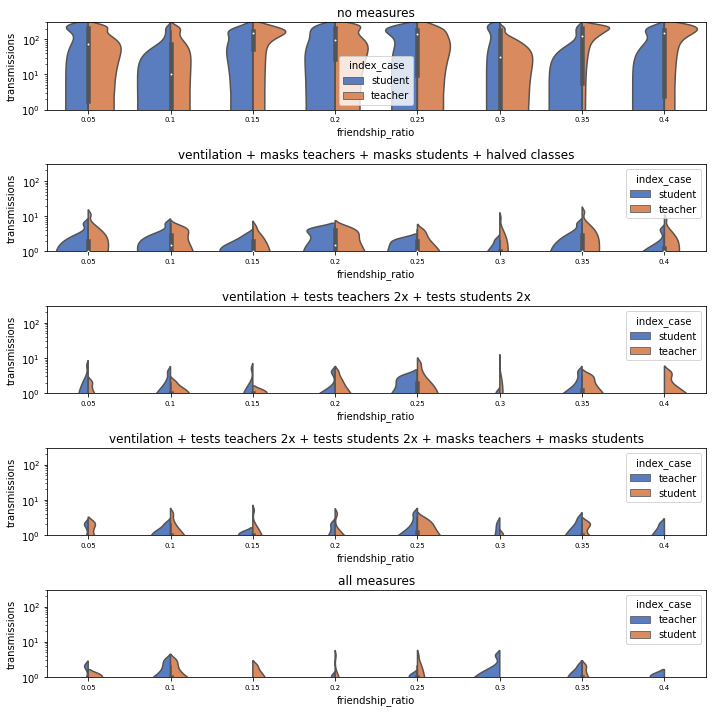

In [17]:
fig, axes = plt.subplots(5, 1, figsize=(10, 10))

for ax, measure in zip(axes.flatten(), results['measure'].unique()):
    subset = results[results['measure'] == measure]
    sns.violinplot(x="friendship_ratio", y="transmissions", hue="index_case",
                   data=subset, palette="muted", split=True, ax=ax)
    ax.tick_params(axis='x', labelsize=7)
    ax.set_yscale('log')
    ax.set_ylim(1, 300)
    ax.set_title(measure)
fig.tight_layout()

## Transmissibility

### Screening parameters

In [27]:
# number of runs in the ensemble (set to a low number so runs complete quickly
# for demonstration purposes)
N_runs = 10
# different school types (only simulate for primary schools for demonstration
# purposes)
school_types = ['primary', 'primary_dc', 'lower_secondary',
                'lower_secondary_dc', 'upper_secondary', 'secondary'][0:1]
# load the other screening parameters from file
screening_params = pd.read_csv(join('screening_params', 'transmissibility.csv'))

params = [(N_runs, st, 
           row['index_case'],
           dcf.format_none_column(row['s_screen_interval']),
           dcf.format_none_column(row['t_screen_interval']),
           row['s_mask'],
           row['t_mask'], 
           row['class_size_reduction'],
           row['ventilation_modification'],
           row['base_transmission_risk_multiplier']) \
           for st in school_types \
           for i, row in screening_params.iterrows()]

### Simulation function

In [28]:
def run_transmissibility(params):
    '''
    Runs an ensemble of simulations and collects observable statistics. To be 
    run in parallel on many workers. Note: I/O paths and the number of runs per 
    ensemble hare hard coded here, because I only want to pass the parameter 
    values that are being screened in the simulation run to the function via the
    parallel processing interface.
    
    Parameters:
    -----------
    param_list : iterable
        Iterable that contains the values for the parameters N_runs, 
        school_type, index_case, s_screen_interval, t_screen_interval, s_mask,
        t_mask, class_size_reduction and base_transmission_risk_multiplier. 
        These parameters are passed to the simulation.
        
    Returns:
    --------
    row : dictionary
        Dictionary of the ensemble statistics of the observables.
    '''    

    # extract the simulation parameters from the parameter list
    N_runs, school_type, index_case, s_screen_interval, t_screen_interval, \
        student_mask, teacher_mask, class_size_reduction, ventilation_mod, \
        base_transmission_risk_multiplier = params
    
    try:
        os.mkdir(join(dst, school_type))
    except FileExistsError:
        pass

    # run the ensemble with the given parameter combination and school type
    ensmbl_results = dcf.run_ensemble(N_runs, school_type, measures,\
            simulation_params, school_characteristics, contact_network_src,\
            dst, index_case, s_screen_interval=s_screen_interval,
            t_screen_interval=t_screen_interval, student_mask=student_mask,
            teacher_mask=teacher_mask,class_size_reduction=class_size_reduction,
            ventilation_mod=ventilation_mod, 
            base_transmission_risk_multiplier=base_transmission_risk_multiplier)
    
    return ensmbl_results

### Running the simulations

In [29]:
%%time
# paths for data I/O
contact_network_src = '../../data/contact_networks/representative_schools'
dst = '../../data/sensitivity_analysis/simulation_results/transmissibility'

number_of_cores = psutil.cpu_count(logical=True) - 2
pool = Pool(number_of_cores)

results = pd.DataFrame()
for ensmbl_results in tqdm(pool.imap_unordered(func=run_transmissibility,
                        iterable=params), total=len(params)):
    results = results.append(ensmbl_results, ignore_index=True)

# turn off your parallel workers 
pool.close()
    
results = results.reset_index(drop=True)
index_cols = ['school_type', 'index_case',
              'student_screen_interval', 'teacher_screen_interval',
              'student_mask', 'teacher_mask', 'class_size_reduction',
              'ventilation_mod', 'base_transmission_risk_multiplier']
other_cols = [c for c in results.columns if c not in index_cols]
results = results[index_cols + other_cols]

results.to_csv(join(dst, 'transmissibility_{}.csv'\
                   .format(N_runs)), index=False)
results.head(3)

100%|██████████| 140/140 [02:35<00:00,  1.11s/it]

CPU times: user 1.64 s, sys: 237 ms, total: 1.88 s
Wall time: 2min 36s


,school_type,index_case,student_screen_interval,teacher_screen_interval,student_mask,teacher_mask,class_size_reduction,ventilation_mod,base_transmission_risk_multiplier,N_diagnostic_tests,...,undetected_infections,test_type,student_testing_rate,teacher_testing_rate,mask_efficiency_exhale,mask_efficiency_inhale,friendship_ratio,student_vaccination_ratio,teacher_vaccination_ratio,family_member_vaccination_ratio
0,primary,student,None,None,False,False,0.0,1.0,0.9,16.0,...,0.0,same_day_antigen,1.0,1.0,0.5,0.7,0.0,0.0,0.0,0.0
1,primary,student,None,None,False,False,0.0,1.0,0.9,3.0,...,0.0,same_day_antigen,1.0,1.0,0.5,0.7,0.0,0.0,0.0,0.0
2,primary,student,None,None,False,False,0.0,1.0,0.9,16.0,...,0.0,same_day_antigen,1.0,1.0,0.5,0.7,0.0,0.0,0.0,0.0


### Evaluate the simulations

In [30]:
dst = '../../data/sensitivity_analysis/simulation_results/transmissibility'
results = pd.read_csv(join(dst, 'transmissibility_{}.csv'.format(N_runs)))
results['student_screen_interval'] = results['student_screen_interval']\
    .replace({np.nan:'never'})
results['teacher_screen_interval'] = results['teacher_screen_interval']\
    .replace({np.nan:'never'})
dcf.set_measure_packages_added_friendship_contacts(results)

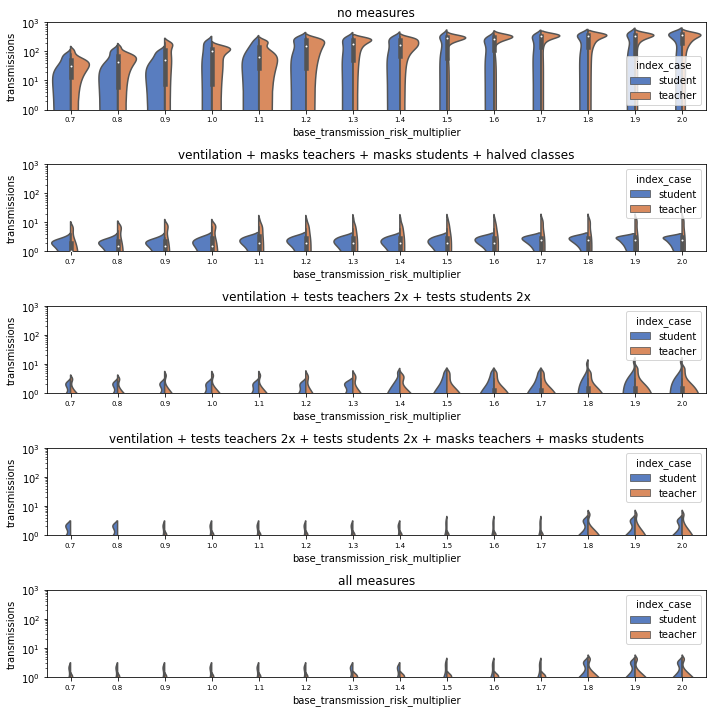

In [32]:
fig, axes = plt.subplots(5, 1, figsize=(10, 10))

for ax, measure in zip(axes.flatten(), results['measure'].unique()):
    subset = results[results['measure'] == measure]
    sns.violinplot(x="base_transmission_risk_multiplier", y="transmissions", hue="index_case",
                   data=subset, palette="muted", split=True, ax=ax)
    ax.tick_params(axis='x', labelsize=7)
    ax.set_yscale('log')
    ax.set_ylim(1, 1000)
    ax.set_title(measure)
fig.tight_layout()

## Worst case

### Screening parameters

In [56]:
# number of runs in the ensemble (set to a low number so runs complete quickly
# for demonstration purposes)
N_runs = 10
# different school types (only simulate for primary schools for demonstration
# purposes)
school_types = ['primary', 'primary_dc', 'lower_secondary',
                'lower_secondary_dc', 'upper_secondary', 'secondary'][0:1]
# load the other screening parameters from file
screening_params = pd.read_csv(join('screening_params', 'worst_case.csv'))

params = [(N_runs, st, 
           row['index_case'],
           dcf.format_none_column(row['s_screen_interval']),
           dcf.format_none_column(row['t_screen_interval']),
           row['s_mask'],
           row['t_mask'], 
           row['class_size_reduction'],
           row['ventilation_modification'],
           row['m_efficiency_exhale'],
           row['m_efficiency_inhale'],
           row['s_test_rate'],
           row['t_test_rate'],
           row['ttype'],
           row['added_friendship_contacts']) \
           for st in school_types \
           for i, row in screening_params.iterrows()]

### Simulation function

In [58]:
def run_worst_case(params):
    '''
    Runs an ensemble of simulations and collects observable statistics. To be 
    run in parallel on many workers. Note: I/O paths and the number of runs per 
    ensemble hare hard coded here, because I only want to pass the parameter 
    values that are being screened in the simulation run to the function via the
    parallel processing interface.
    
    Parameters:
    -----------
    param_list : iterable
        Iterable that contains the values for the parameters N_runs, 
        school_type, index_case, s_screen_interval, t_screen_interval, s_mask,
        t_mask, class_size_reduction, ventilation_modification, 
        mask_efficiency_exhale, mask_efficiency_inhale, s_testing_rate,
        t_testing_rate, ttype (encoding test sensitivity) and friendship_ratio.
        These parameters are passed to the simulation.
        
    Returns:
    --------
    row : dictionary
        Dictionary of the ensemble statistics of the observables.
    '''    

    # extract the simulation parameters from the parameter list
    N_runs, school_type, index_case, s_screen_interval, t_screen_interval, \
        student_mask, teacher_mask, class_size_reduction, ventilation_mod, \
        mask_efficiency_exhale, mask_efficiency_inhale, s_testing_rate, \
        t_testing_rate, ttype, friendship_ratio = params
    
    try:
        os.mkdir(join(dst, school_type))
    except FileExistsError:
        pass

    # run the ensemble with the given parameter combination and school type
    ensmbl_results = dcf.run_ensemble(N_runs, school_type, measures,\
            simulation_params, school_characteristics, contact_network_src,\
            dst, index_case, s_screen_interval=s_screen_interval,
            t_screen_interval=t_screen_interval, student_mask=student_mask,
            teacher_mask=teacher_mask,class_size_reduction=class_size_reduction,
            ventilation_mod=ventilation_mod, 
            mask_efficiency_exhale=mask_efficiency_exhale,
            mask_efficiency_inhale=mask_efficiency_inhale,
            s_testing_rate=s_testing_rate, t_testing_rate=t_testing_rate,
            ttype=ttype, friendship_ratio=friendship_ratio)
    
    return ensmbl_results

### Running the simulations

In [60]:
%%time
# paths for data I/O
contact_network_src = '../../data/contact_networks/worst_case'
dst = '../../data/sensitivity_analysis/simulation_results/worst_case'

number_of_cores = psutil.cpu_count(logical=True) - 2
pool = Pool(number_of_cores)

results = pd.DataFrame()
for ensmbl_results in tqdm(pool.imap_unordered(func=run_worst_case,
                        iterable=params), total=len(params)):
    results = results.append(ensmbl_results, ignore_index=True)

# turn off your parallel workers 
pool.close()
    
results = results.reset_index(drop=True)
index_cols = ['school_type', 'index_case',
              'student_screen_interval', 'teacher_screen_interval',
              'student_mask', 'teacher_mask', 'class_size_reduction',
              'ventilation_mod']
other_cols = [c for c in results.columns if c not in index_cols]
results = results[index_cols + other_cols]

results.to_csv(join(dst, 'worst_case_{}.csv'\
                   .format(N_runs)), index=False)
results.head(3)

100%|██████████| 18/18 [00:21<00:00,  1.22s/it]

CPU times: user 207 ms, sys: 124 ms, total: 331 ms
Wall time: 22.1 s


,school_type,index_case,student_screen_interval,teacher_screen_interval,student_mask,teacher_mask,class_size_reduction,ventilation_mod,N_diagnostic_tests,N_family_members,...,test_type,student_testing_rate,teacher_testing_rate,base_transmission_risk_multiplier,mask_efficiency_exhale,mask_efficiency_inhale,friendship_ratio,student_vaccination_ratio,teacher_vaccination_ratio,family_member_vaccination_ratio
0,primary,student,7,7,False,False,0.3,0.8,7.0,357.0,...,same_day_antigen0.4,0.5,0.5,1.0,0.8,0.6,0.2,0.0,0.0,0.0
1,primary,student,7,7,False,False,0.3,0.8,1.0,357.0,...,same_day_antigen0.4,0.5,0.5,1.0,0.8,0.6,0.2,0.0,0.0,0.0
2,primary,student,7,7,False,False,0.3,0.8,1.0,357.0,...,same_day_antigen0.4,0.5,0.5,1.0,0.8,0.6,0.2,0.0,0.0,0.0


### Evaluate the simulations

In [79]:
dst = '../../data/sensitivity_analysis/simulation_results/worst_case'
results = pd.read_csv(join(dst, 'worst_case_{}.csv'.format(N_runs)))
results['student_screen_interval'] = results['student_screen_interval']\
    .replace({np.nan:'never'})
results['teacher_screen_interval'] = results['teacher_screen_interval']\
    .replace({np.nan:'never'})
dcf.set_measure_packages_worst_case(results)

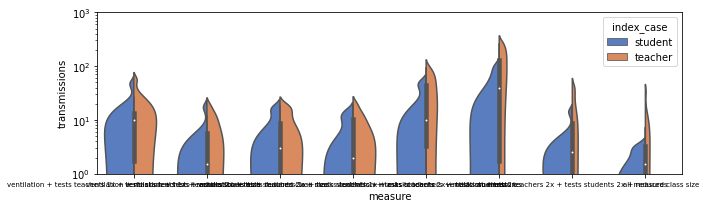

In [83]:
fig, ax = plt.subplots(figsize=(10, 3))

sns.violinplot(x="measure", y="transmissions", hue="index_case",
               data=results, palette="muted", split=True, ax=ax)
ax.tick_params(axis='x', labelsize=7)
ax.set_yscale('log')
ax.set_ylim(1, 1000)
fig.tight_layout()